In [ ]:
import numpy as np
from numpy import sqrt, arange 

import pandas as pd
from pandas import read_csv

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import random

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, mean_absolute_percentage_error

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, BaggingClassifier

from sklearn import model_selection
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import xgboost as xgb
from xgboost import XGBRegressor

In [ ]:
link = "https://raw.githubusercontent.com/akotsovo/ASIM-Coins/main/clean/santiment_final_data.csv"

data = pd.read_csv(link)

data['datetime'] = pd.to_datetime(data['datetime'])

data['date'] = data['datetime'].dt.date

data = data.set_index('date')

data = data.drop(columns=["Unnamed: 0", "datetime"])

In [ ]:
# feature correleation bike_set
#plt.figure(figsize = (28,20))
#ax= sns.heatmap(data.corr(), annot = True, cmap="coolwarm",linewidth =1,vmin=-0.6, vmax=1)
#plt.show()

In [ ]:
#training_data, testing_data = train_test_split(data, test_size=0.2, random_state=25)

X = data.drop(columns="monero_prices")
y = data["monero_prices"]

In [ ]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [ ]:
#train and test set for cross-validation of the results using the train_test_split function from sklearn's model_selection module with test_size size equal to 30% of the data. Also, to maintain reproducibility of the results, a random_state is also assigned.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Then split the train dataset into train (50%) and validation (20% = 0.28571429 * 0,5) data set
X_train, X_val, y_train, y_val  = train_test_split(X_train, y_train, test_size=0.28571429, random_state=42)

In [ ]:
#instantiate an XGBoost regressor object
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.04,
                max_depth = 7, gamma = 1.5, n_estimators = 500, subsample = 0.8)

In [ ]:
#Fit the regressor to the training set and make predictions on the validation set
xg_reg.fit(X_train,y_train)

preds = xg_reg.predict(X_val)

In [ ]:
# Print out relevant error metrics
print("R^2 for Train = %.4f" % xg_reg.score(X_train, y_train))
print("R^2 for Validation = %.4f" % r2_score(y_val, preds))
print("MAE = %.4f " % mean_absolute_error(y_val, preds))
print("MSE = %.4f " % mean_squared_error(y_val, preds))
print("RMSE = %.4f " % np.sqrt(mean_squared_error(y_val, preds)))
print("MAPE = %.4f " % (mean_absolute_percentage_error(y_val, preds)))

R^2 for Train = 1.0000
R^2 for Validation = 0.9790
MAE = 4.8897 
MSE = 46.3356 
RMSE = 6.8070 
MAPE = 0.0244 


In [ ]:
# First create a possible value space for each parameter and put all into one grid (dictionary)
max_depth = [4,5,6,7,8]
learning_rate = [float(x) for x in np.linspace(0.01 ,0.3 ,num=5)]
subsample = [0.7, 0.8, 0.9]
n_estimators = [int(x) for x in np.linspace(100,800,num=10)]
colsample_bytree = [0.4, 0.5,0.6]
gamma = [float(x) for x in np.linspace(0.5 ,4,num=5)]

hyperparameter_random_grid = {"max_depth": max_depth,
                                "learning_rate": learning_rate,
                                "n_estimators": n_estimators,
                                "subsample": subsample,
                                "colsample_bytree": colsample_bytree,
                                "gamma": gamma
                               }
# Create the random search with the above parameter grid, 3 folds of cross validation and 500 random iterations
random_search = RandomizedSearchCV(estimator = XGBRegressor(), param_distributions = hyperparameter_random_grid, 
                           cv = 3, n_jobs = -1, verbose = 4, scoring="r2", n_iter = 500, random_state=42)

random_search.fit(X_train, y_train)
random_search.best_params_

Fitting 3 folds for each of 500 candidates, totalling 1500 fits
[22:00:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


{'subsample': 0.7,
 'n_estimators': 800,
 'max_depth': 4,
 'learning_rate': 0.01,
 'gamma': 3.125,
 'colsample_bytree': 0.6}

In [ ]:
#perform GridSearch to tune hyperparameters
gsc = GridSearchCV(estimator=XGBRegressor(),
                    param_grid={"max_depth": (3,4,5),
                                "learning_rate": (0.01, 0.02),
                                "n_estimators": [780, 800, 820],
                                "subsample":(0.6,0.7,0.8),
                                "colsample_bytree":(0.5, 0.6, 0.7),
                                "gamma" : (3.0, 3.125, 3.2)
                               },
                    cv=5,
                    scoring="r2",
                    verbose=4, #possibly 10 when takes too long
                    n_jobs=-1,
)

grid_result = gsc.fit(X_train, y_train)

Fitting 5 folds for each of 486 candidates, totalling 2430 fits
[23:39:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
#get the best parameters
gsc.best_params_

{'colsample_bytree': 0.7,
 'gamma': 3.0,
 'learning_rate': 0.02,
 'max_depth': 3,
 'n_estimators': 820,
 'subsample': 0.6}

In [ ]:
#Apply hyperparameters to the model and fit the regressor to the training set and make predictions on the validation set
xg_reg_g = xgb.XGBRegressor(max_depth=3, learning_rate=0.02, n_estimators=820,
                 objective="reg:squarederror", subsample=0.6,
                 colsample_bytree=0.7, gamma = 3.0)
xg_reg_g.fit(X_train,y_train)

preds_g = xg_reg_g.predict(X_val)

In [ ]:
# Print out relevant error metrics
print("R^2 for Train = %.4f" % xg_reg_g.score(X_train, y_train))
print("R^2 for Validation = %.4f" % r2_score(y_val, preds_g))
print("MAE = %.4f " % mean_absolute_error(y_val, preds_g))
print("MSE = %.4f " % mean_squared_error(y_val, preds_g))
print("RMSE = %.4f " % np.sqrt(mean_squared_error(y_val, preds_g)))
print("MAPE = %.4f " % (mean_absolute_percentage_error(y_val, preds_g)))

R^2 for Train = 0.9999
R^2 for Validation = 0.9932
MAE = 2.7647 
MSE = 14.8791 
RMSE = 3.8573 
MAPE = 0.0142 


In [ ]:
#get the importance of the features
importances = xg_reg_g.feature_importances_
#Sort it
print ("Sorted Feature Importance:")
sorted_feature_importance = sorted(zip(importances, list(X_train)), reverse=True)
print (sorted_feature_importance)

important_variable_values=sorted([i[0] for i in sorted_feature_importance[0:10]])
important_variable_names=[i[1] for i in sorted_feature_importance[0:10]]
print (important_variable_values)
print (important_variable_names)

Sorted Feature Importance:
[(0.23853642, 'social_volume_telegram_ripple'), (0.16038314, 'social_volume_telegram_bitcoin'), (0.14850897, 'sentiment_positive_twitter_ethereum'), (0.05887935, 'sentiment_positive_total_ethereum'), (0.052403163, 'social_dominance_total_stellar'), (0.032433134, 'stellar_prices'), (0.03206021, 'social_volume_telegram_ethereum'), (0.030698601, 'monero_marketcap'), (0.029205816, 'social_volume_twitter_ethereum'), (0.02621418, 'sentiment_negative_twitter_bitcoin'), (0.023803042, 'social_dominance_total_cardano'), (0.016185047, 'ripple_prices'), (0.015848553, 'ethereum_prices'), (0.0141688725, 'social_volume_telegram_avalanche'), (0.009571494, 'social_volume_telegram_stellar'), (0.009374197, 'avalanche_marketcap'), (0.00926973, 'sentiment_positive_telegram_cardano'), (0.0074702506, 'sentiment_negative_twitter_ethereum'), (0.0071785115, 'cardano_prices'), (0.006767312, 'cardano_marketcap'), (0.006674464, 'bitcoin_marketcap'), (0.006513398, 'bitcoin_prices'), (0.00

In [ ]:
importance = pd.DataFrame(sorted_feature_importance)
importance

,0,1
0,0.238536,social_volume_telegram_ripple
1,0.160383,social_volume_telegram_bitcoin
2,0.148509,sentiment_positive_twitter_ethereum
3,0.058879,sentiment_positive_total_ethereum
4,0.052403,social_dominance_total_stellar
...,...,...
412,0.000000,dev_activity_contribution_count_monero
413,0.000000,dev_activity_contribution_count_ethereum
414,0.000000,dev_activity_contribution_count_avalanche
415,0.000000,dev_activity_bitcoin


In [ ]:
# predict on the test set
preds = xg_reg_g.predict(X_test)

# Print out relevant error metrics
print("R^2 for Train = %.4f" % xg_reg_g.score(X_train, y_train))
print("R^2 for Test = %.4f" % r2_score(y_test, preds))
print("MAE = %.4f " % mean_absolute_error(y_test, preds))
print("MSE = %.4f " % mean_squared_error(y_test, preds))
print("RMSE = %.4f " % np.sqrt(mean_squared_error(y_test, preds)))
print("MAPE = %.4f " % (mean_absolute_percentage_error(y_test, preds)))

R^2 for Train = 0.9999
R^2 for Test = 0.9916
MAE = 2.9575 
MSE = 18.1636 
RMSE = 4.2619 
MAPE = 0.0154 


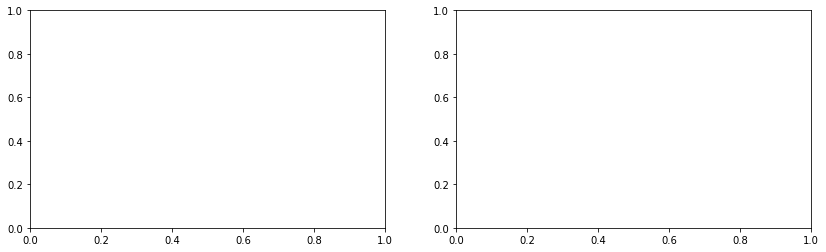

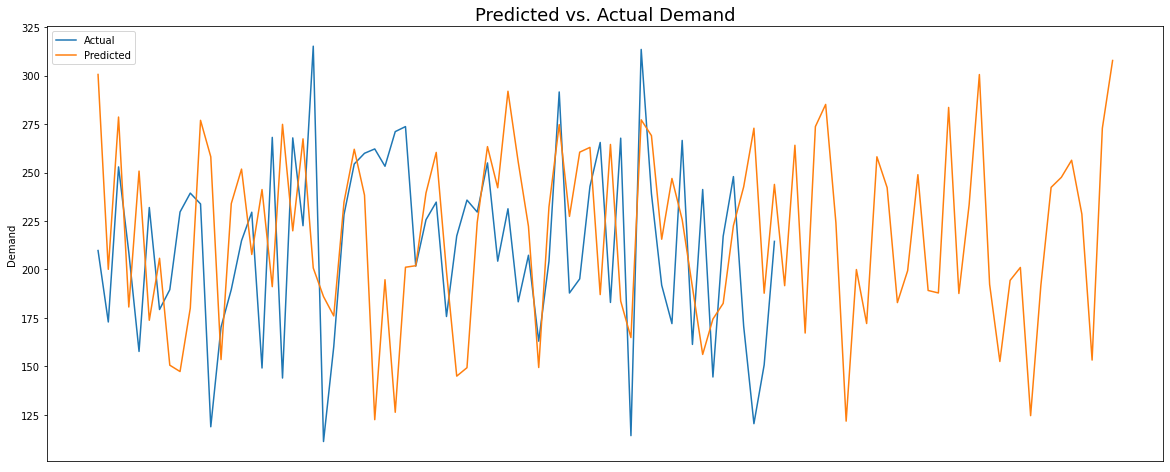

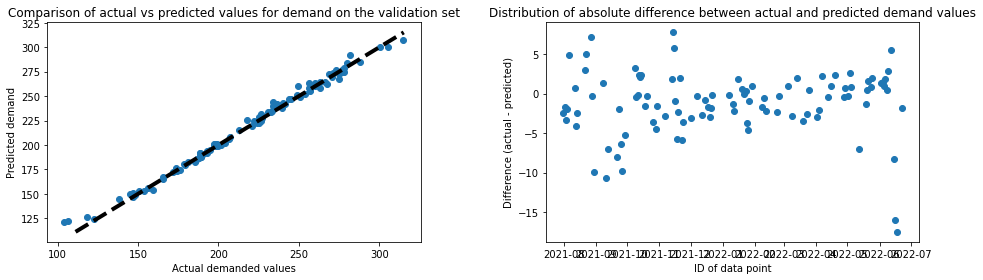

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(14,4))

# Plotting Actual vs Predicted Demand
fig,ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(20)
l1,=ax.plot(range(len(y_val)),y_val)
l2, = ax.plot(range(len(preds)),preds)
plt.legend([l1,l2],['Actual','Predicted'])
plt.title('Predicted vs. Actual Demand', fontsize= 18)
plt.ylabel('Demand')
plt.xticks([])
plt.show()
    
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(14,4))

# First, plot the values for actual and predicted demand
ax[0].scatter(y_test, preds)
ax[0].plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=4)  # Plot a line for the optimal prediction values
ax[0].set_xlabel("Actual demanded values")
ax[0].set_ylabel("Predicted demand")
ax[0].set_title("Comparison of actual vs predicted values for demand on the validation set")

# Next, plot the actual difference between both values
ax[1].plot(y_test-preds, marker = 'o', linestyle = '')
ax[1].set_xlabel("ID of data point")
ax[1].set_ylabel("Difference (actual - predicted)")
ax[1].set_title("Distribution of absolute difference between actual and predicted demand values")

fig.tight_layout()